In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile, isdir, join, splitext
import glob
import shutil
from collections import Counter, defaultdict
import datetime
from process_raw_prices import get_filename_without_ext

%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["font.size"] = 12

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def my_read_csv(p):
    df = pd.read_csv(p)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    return df


def recreate_dir(folder):
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

In [3]:
# parameters for trimming data
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date(2019, 1, 5)
raw_folder = "../../dataset/nyse-daily/"
trimmed_folder = "../../dataset/nyse-daily-trimmed/"
result_folder = "../../dataset/nyse-daily-trimmed-same-length/"
raw_files_path_pattern = raw_folder+"*.csv"
trimmed_files_path_pattern = trimmed_folder+"*.csv"

There are 170 stock data.


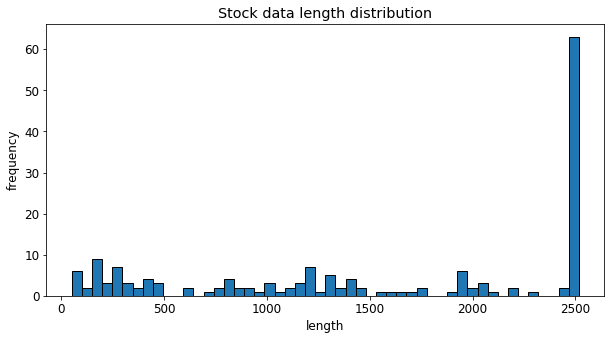

In [4]:
# raw dataset files pattern
nyse_csv_paths = sorted(glob.glob(raw_files_path_pattern))
lengths = [len(pd.read_csv(p)) for p in nyse_csv_paths]
print("There are {} stock data csv files.".format(len(nyse_csv_paths)))
n, bins, patches = plt.hist(lengths, 50)
plt.xlabel('length')
plt.ylabel('frequency')
plt.title('Stock data length distribution')
plt.gcf().set_size_inches(10, 5)
# plt.show()

In [5]:
# trim data and put them into a trimmed folder
recreate_dir(trimmed_folder)

for p in nyse_csv_paths:
    filename = get_filename_without_ext(p)
    df = my_read_csv(p)
    df = df[(pd.Timestamp(start_date) <= df['date']) & (df['date'] < pd.Timestamp(end_date))]
    df.to_csv(path_or_buf=join(trimmed_folder, filename + '.csv'), index=False)

There are 170 trimmed stock data.


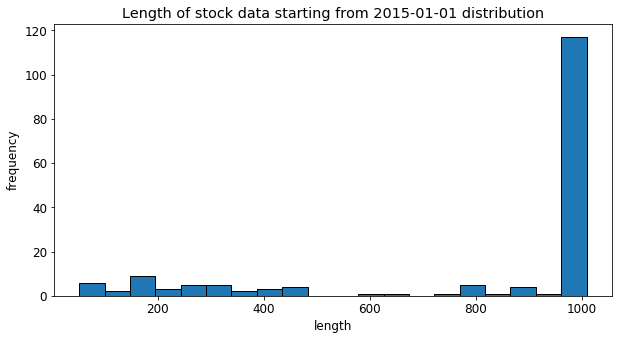

In [6]:
nyse_trimmed_csv_paths = sorted(glob.glob(trimmed_files_path_pattern))

lengths = [len(pd.read_csv(p)) for p in nyse_trimmed_csv_paths]
print("There are {} trimmed stock data.".format(len(nyse_trimmed_csv_paths)))
n, bins, patches = plt.hist(lengths, 20)
plt.xlabel('length')
plt.ylabel('frequency')
plt.title('Length of stock data starting from {} distribution'.format(str(start_date)))
plt.gcf().set_size_inches(10, 5)
# plt.show()

max_length = max(lengths)
max_length_data = []
max_length_data_path = []
for p in nyse_trimmed_csv_paths:
    temp_df = pd.read_csv(p)
    if len(temp_df) == max_length:
        max_length_data.append(temp_df)
        max_length_data_path.append(p)

In [7]:
# find intersection of the max length group of stocks
intersection = max_length_data[0]['date'].values
for temp_df in max_length_data[1:]:
    intersection, _, __ = np.intersect1d(
        intersection,
        temp_df['date'].values,
        assume_unique=True, return_indices=True
    )

In [8]:
if len(intersection) == max_length:
    print('All stock data starting from date {} with {} data points each have common trading date.'.format(
        str(start_date), max_length
    ))
    
    # save those stocks in a result folder
    recreate_dir(result_folder)
    
    for p in max_length_data_path:
        shutil.copy(p, result_folder)
    print('The processed dataset was placed in:', result_folder)
    print('There should be {} csv files.'.format(len(max_length_data_path)))
else:
    print('All stock data starting from date {} with max length do not have common trading date.'.format(str(start_date)))
    print('ERROR: need to do some other complicated preprocessing')

All stock data starting from date 2015-01-01 with 1009 data points each have common trading date.
The processed dataset was placed in: ../../dataset/nyse-daily-trimmed-same-length/
There should be 116 csv files.
